In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import Sky_area_generator
import healpy as hp
import sqlite3
import pandas as pd

In [2]:
nside = 32
sm = Sky_area_generator(nside=nside)
footprints_hp_array, labels = sm.return_maps()

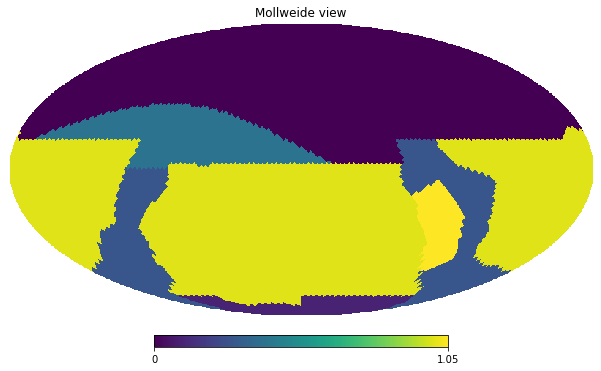

In [3]:
hp.mollview(footprints_hp_array['r'])

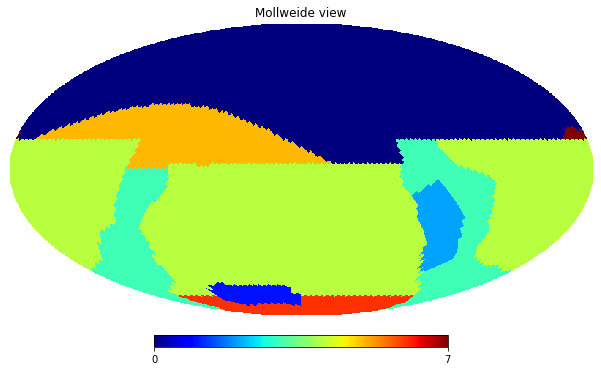

In [4]:
label_map = footprints_hp_array['r']*0
for i,label in enumerate(np.unique(labels)):
    good = np.where(labels == label)[0]
    label_map[good] = i
hp.mollview(label_map, cmap='jet')
plt.savefig('map_labels.pdf')

In [5]:

outDir='time_fractions'
resultsDb = maf.db.ResultsDb(outDir=outDir)


Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Querying table None with constraint note not like "%DD%" for columns ['rotSkyPos', 'fieldDec', 'night', 'fieldRA']
Found 1987787 visits
Running:  ['baseline_v2_1_10yrs_Count_night_note_not_like_DD_HEAL']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "note not like "%DD%"" constraint now.
Plotting complete.


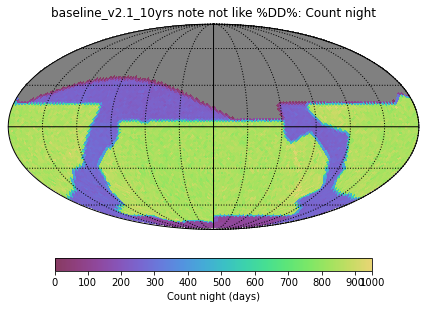

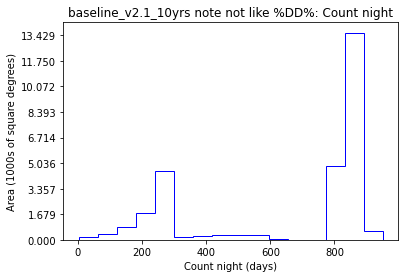

In [7]:
bundleList = []

sql = 'note not like "%DD%"'
metric = maf.metrics.CountMetric(col='night')
slicer = maf.slicers.HealpixSlicer(nside=nside)
summaryStats = [maf.metrics.MedianMetric()]
plotDict = {}
bundleList.append(maf.metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                                runName='baseline_v2.1_10yrs'))
bg = maf.metricBundles.MetricBundleGroup(bundleList, '/Users/yoachim/runs21/baseline/baseline_v2.1_10yrs.db', outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [8]:
ulabels = list(np.unique(labels))

In [9]:
etendue = []
for label in ulabels:
    good = np.where(labels == label)
    etendue.append(np.sum(bundleList[0].metricValues[good]))

In [10]:
etendue/np.sum(etendue)

array([0.00839485, 0.02127578, 0.04292318, 0.06637534, 0.80399876,
       0.04494877, 0.00873936, 0.00334397])

In [12]:
# grab the number of observations
conn = sqlite3.connect('/Users/yoachim/runs21/baseline/baseline_v2.1_10yrs.db')
n_all = pd.read_sql('select count(night) from observations;', conn).values.ravel()
n_ddf = pd.read_sql('select count(night) from observations where note like "DD%";', conn).values.ravel()


In [13]:
n_all, n_ddf

(array([2081749]), array([93962]))

In [14]:
counts = list(etendue/np.sum(etendue)*(n_all-n_ddf))
counts.append(np.max(n_ddf))
ulabels.append('DDFs')

In [22]:
a = np.array([ulabels, counts, counts/np.sum(counts)])
df = pd.DataFrame(a.T, columns=['Label', 'N visits', 'Percent'])

In [23]:
df1 = df.copy()
df1['N visits'] = np.trunc(10 * df1['N visits'].values.astype(float)) / 10
df1['Percent'] = np.trunc(10000 * df1['Percent'].values.astype(float)) / 100


In [24]:
df1

,Label,N visits,Percent
0,,16687.1,0.80
1,LMC_SMC,42291.7,2.03
2,bulge,85322.1,4.09
3,dusty_plane,131940.0,6.33
4,lowdust,1598178.2,76.77
5,nes,89348.5,4.29
6,scp,17371.9,0.83
7,virgo,6647.0,0.31
8,DDFs,93962.0,4.51


In [26]:
print(df1.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
      Label &  N visits &  Percent \\
\midrule
            &   16687.1 &     0.80 \\
    LMC\_SMC &   42291.7 &     2.03 \\
      bulge &   85322.1 &     4.09 \\
dusty\_plane &  131940.0 &     6.33 \\
    lowdust & 1598178.2 &    76.77 \\
        nes &   89348.5 &     4.29 \\
        scp &   17371.9 &     0.83 \\
      virgo &    6647.0 &     0.31 \\
       DDFs &   93962.0 &     4.51 \\
\bottomrule
\end{tabular}

